### Imports

In [1]:
# For Docker image tensorflow/tensorflow:2.14.0-gpu-juptyer and latest-gpu-jupyter 
# About the latest tag: sha256:efc25f8ad0ec337e8f4e2de9e7e8e391e6729481c7a7cae4bdea3137da7822c6
!pip install -q emoji
!pip install -q nltk
!pip install -q transformers
!pip install -q tf-keras
!pip install -q scikit-learn

In [2]:
from emoji import demojize, is_emoji
from typing import Union
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import numpy as np
from numpy import ndarray
from sklearn.metrics import f1_score
import tensorflow as tf

2024-04-26 22:00:56.421876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# The device_name will be used in model.fit()
gpu_devices = tf.config.experimental.list_physical_devices("GPU")

if gpu_devices:
    print("GPU available, using GPU")
    tf.config.experimental.set_visible_devices(gpu_devices[0], "GPU")
    device_name = "/GPU:0"
else:
    print("GPU not available, using CPU")
    device_name = "/CPU:0"

GPU available, using GPU


2024-04-26 22:00:57.537323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:00:57.541463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:00:57.541500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Function for loading data set

In [4]:
def load_text_file(file_path: str) -> list[str]:
    """
    Load a text file and return an array of lines from the file.

    Args:
        file_path: str: The path to the file to load.

    Returns:
        list[str]: An array of lines from the file.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

### Load the text files

In [5]:
train_text_path: str = "../dataset/train_text.txt"
train_label_path: str = "../dataset/train_labels.txt"

test_text_path: str = "../dataset/test_text.txt"
test_label_path: str = "../dataset/test_labels.txt"

validationt_text_path: str = "../dataset/val_text.txt"
validationt_label_path: str = "../dataset/val_labels.txt"

train_text: list[str] = load_text_file(train_text_path)
train_label: list[str] = load_text_file(train_label_path)

test_text: list[str] = load_text_file(test_text_path)
test_label: list[str] = load_text_file(test_label_path)

validation_text: list[str] = load_text_file(validationt_text_path)
validation_label: list[str] = load_text_file(validationt_label_path)

### Preprocessing

#### Download the NLTK resources and declere global variables

In [6]:
# Set stopwords
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("vader_lexicon", quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
stopwords = set(nltk.corpus.stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

### Functions for preprocessing

In [7]:
def text_processing(text: list[str]) -> list[str]:
    """
    Process text data:    
    - Remove "@user"
    - Remove "#".
    - Replace "’" and triple dots in one character (…).
    - Tokenize and lowercase.
    - Normalize the tokens and join the line.
    - Replace specific strings.
    - Remove excess space after processing.

    Args:
        text: list[str]: A list of text data.

    Returns:
        list[str]: A list of processed sentences
    """
    processed_text = []
    for line in text:
        # Remove @user
        line = line.replace("@user", "")
        # Remove #
        line = line.replace("#", "")
        # Replace "’" and triple dots in one character (…)
        line = line.replace("’", "'").replace("…", "...")
        # Tokenize and lowercase
        tokens = tokenizer.tokenize(line.lower())
        # Normalize the tokens and join the line
        line = " ".join([normalize_token(token) for token in tokens])
        # Replace specific strings
        line = (
            line.replace("cannot", "can not")
            .replace("can't", "can not")
            .replace("n't ", " not ")
            # Handle cases in English, where when "n't" is replace with
            # " not ", the meaning of the word will be invalid
            .replace("wo not ", "will not ")
            .replace("sha not", "shall not")
            # "ain't" can be "am/is/are not", so it stays
            .replace("ai not ", "ain't ")
        )
        line = (
            line.replace("'m ", " am ")
            .replace("'re ", " are ")
            .replace("'ll ", " will ")
            .replace("'ve ", " have ")
            # 's can mean ownership or "is"
            .replace("'s ", " 's ")
            # 'd can mean "would" or "had"
            .replace("'d ", " 'd ")
        )
        # Remove excess spaces
        line = " ".join(line.split())
        processed_text.append(line)
    
    return processed_text


def normalize_token(token: str) -> str:
    """
    Normalize the provided token.
    - Replace URLs with "HTTPURL".
    - Replace emojis with respective string.

    Args:
        token: str: The string being normalized

    Return:
        str: The normalized string
    """
    if token.startswith("http") or token.startswith("www"):
        return "HTTPURL"
    elif is_emoji(token):
        return demojize(token)
    else:
        return token

### Process the text data

#### Process all text data

See function docstring from text_processing()

In [8]:
train_text: list[str] = text_processing(train_text)
test_text: list[str] = text_processing(test_text)
validation_text: list[str] = text_processing(validation_text)

##### Convert the labels to integers

In [9]:
validation_labels = [int(x) for x in validation_label]
train_labels = [int(x) for x in train_label]
test_labels = [int(x) for x in test_label]

### Transformer

In [10]:
from transformers import BertConfig, BertTokenizer, TFBertForSequenceClassification

In [11]:
# Configurable parameters
number_of_epochs: int = 2
batch_size: int = 16
dropout_rate = 0.3
learning_rate = 0.00001

tf.random.set_seed(2024)

custom_config = BertConfig.from_pretrained('bert-base-uncased')
custom_config.hidden_dropout_prob = dropout_rate
custom_config.num_labels = 3

In [12]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=custom_config)

2024-04-26 22:01:02.387183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:01:02.387250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:01:02.387266: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:01:02.486273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:01:02.486321: I external/local_xla/xla/stream_executor

In [13]:
# Tokenize and pad sequences
train_encodings = tokenizer(train_text, padding=True, truncation=True, return_tensors='tf')
validation_encodings = tokenizer(validation_text, padding=True, truncation=True, return_tensors='tf')

In [14]:
# Convert labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(tf.one_hot(train_labels, 3))
validation_labels = tf.convert_to_tensor(tf.one_hot(validation_labels, 3))

In [15]:
# Define the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [16]:
# For the history
train_loss: list[float] = []
train_accuracy: list[float] = []
validation_loss: list[float] = []
validation_accuracy: list[float] = []

In [17]:
# Train the model
# Because model.fit() will crash if I put validation_data inside
# I created a manual version of history = model.fit(), with validation data
with tf.device(device_name):
    for i in range(number_of_epochs):
        model.fit(train_encodings, train_labels, batch_size=batch_size)
        # Get the loss and accuracy after the current epoch
        loss, accuracy = model.evaluate(train_encodings, train_labels, verbose=0)
        train_loss.append(loss)
        train_accuracy.append(accuracy)
        loss, accuracy = model.evaluate(validation_encodings, validation_labels, verbose=0)
        validation_loss.append(loss)
        validation_accuracy.append(accuracy)
        print(f"Epoch {i+1} done. Validation accuracy: {accuracy}, loss: {loss}")

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1714168917.631328   68002 service.cc:145] XLA service 0x7f11d8a56b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714168917.631366   68002 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-04-26 22:01:57.636994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-26 22:01:57.649197: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1714168917.689789   68002 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2851/2851 [==============================] - 556s 178ms/step - loss: 0.7120 - accuracy: 0.6739
Epoch 1 done. Validation accuracy: 0.7245000004768372, loss: 0.6204398274421692
2851/2851 [==============================] - 503s 176ms/step - loss: 0.6016 - accuracy: 0.7299
Epoch 2 done. Validation accuracy: 0.7354999780654907, loss: 0.6163877248764038


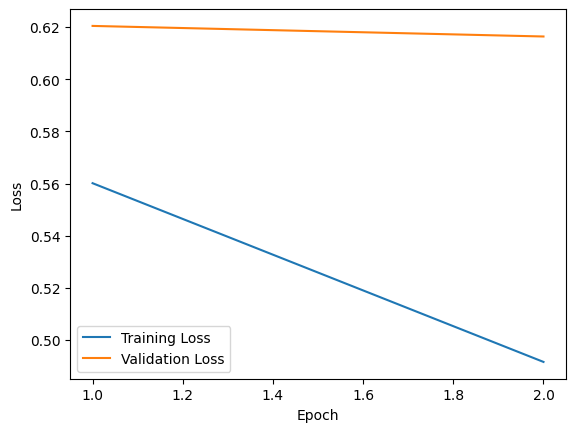

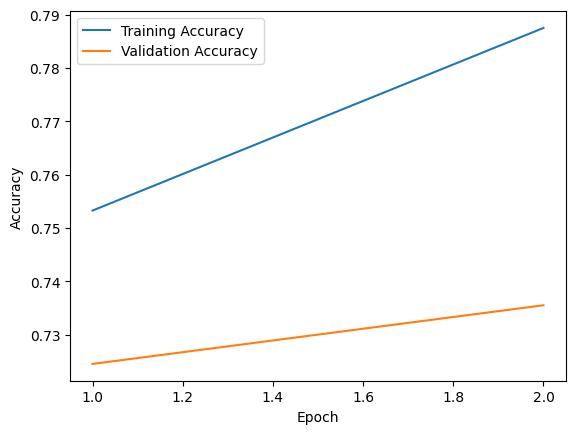

In [18]:
# Plot the graph
epochs = range(1, number_of_epochs+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Final test on the trained model

In [19]:
# Encode the test labels and convert them to tensors
test_encodings = tokenizer(test_text, padding=True, truncation=True, return_tensors='tf')
test_labels = tf.convert_to_tensor(tf.one_hot(test_labels, 3))

loss, accuracy = model.evaluate(test_encodings, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

384/384 [==============================] - 51s 133ms/step - loss: 0.6669 - accuracy: 0.7019
Test Loss: 0.6669390201568604, Test Accuracy: 0.7018886208534241


In [20]:
# Find the marco f1 score
prediction = model.predict(test_encodings)
converted_prediction = np.argmax(prediction.logits, axis=1)
test_labels = np.argmax(test_labels, axis=1)
f1_scores = f1_score(test_labels, converted_prediction, average=None)
macro_average_f1 = np.mean(f1_scores)
print("F1 scores for each class:", f1_scores)
print("Macro-averaged F1 score:", macro_average_f1)

384/384 [==============================] - 55s 129ms/step
F1 scores for each class: [0.70190329 0.70720378 0.68915371]
Macro-averaged F1 score: 0.6994202606557532


## Experiment Zone

In [21]:
prediction_matrix: np.ndarray = prediction.logits

In [22]:
print(prediction_matrix)

[[ 2.8045814   0.9401121  -2.5055816 ]
 [-0.50557226  0.95278114  0.1970147 ]
 [ 1.2571694   1.3093456  -1.3292245 ]
 ...
 [ 0.20808825  2.1616862  -1.0023472 ]
 [ 2.8933647  -0.8647859  -1.8788793 ]
 [-2.7946093   0.535397    2.4822125 ]]


In [35]:
final_result: list[int] = []
netural_range: float =  0.00

# Adjust decision method, make the model tend to predict
# "Netural" more, according to the distribution of the dataset
for row in prediction_matrix:
    # If either the score of positive or negative class is in the
    # +-50% range of the netural score, and the remaining class is
    # not significant higher that the netural class ()
    # It will be classified as netural

    # If the class with the highest score is netural
    if np.max(row) == row[1]:
        final_result.append(1)
        continue
    
    negative: float = row[0]
    netural: float = row[1]
    positive: float = row[2]

    # Get the netural score range
    min_netural: float = netural * (1 - netural_range)
    max_netural: float = netural * (1 + netural_range)

    # If score for negative is in netural range and it is the class with highest score
    if min_netural <= negative <= max_netural and np.max(row) == negative:
        final_result.append(1)
    # If score for positive is in netural range and it is the class with highest score
    elif min_netural <= positive <= max_netural and np.max(row) == positive:
        final_result.append(1)
    elif np.max(row) == negative:
        final_result.append(0)
    elif np.max(row) == positive:
        final_result.append(2)

f1_scores_processed = f1_score(test_labels, final_result, average=None)
macro_average_f1_processed = np.mean(f1_scores_processed)
print("F1 scores for each class:", f1_scores_processed)
print("Macro-averaged F1 score:", macro_average_f1_processed)

F1 scores for each class: [0.70190329 0.70720378 0.68915371]
Macro-averaged F1 score: 0.6994202606557532


## TODO

other transformers

effect on processings